Nesse momento, utilizaremos modelos de suavização exponencial, que utilizam pesos exponencialmente decrescentes para observações passadas, priorizando observações mais recentes. Pode ser útil para caso nossos dados mudarem ao longo do tempo, mas com alguma regularidade.

Inicialmente, vamos aplicar um modelo de suavização exponencial simples, e depois seguir para métodos mais avançados como Holt Winters.

In [1]:
import random

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.structural import UnobservedComponents


In [2]:
random.seed(30)

df = pd.read_csv("data/us_change.csv", index_col=0)
df.head()

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1


In [3]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [4]:
flt = (df["Quarter"] >= "1970Q1") & (df["Quarter"] <= "2019Q2")
Consumption = df[["Quarter", "Consumption"]][flt]
Consumption.set_index("Quarter", inplace=True)

MAE: 0.95
RMSE: 1.00
MASE: 1.55
R²: -9.26


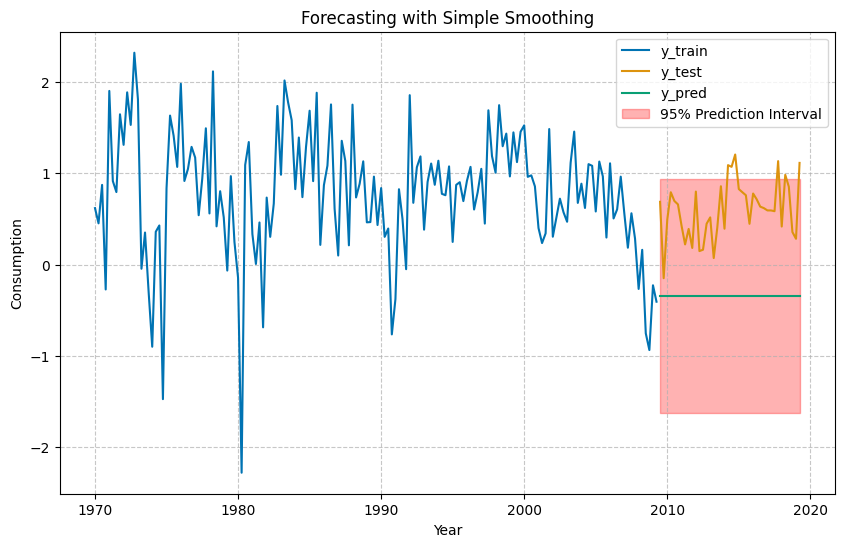

In [5]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Função para calcular o MASE (Mean Absolute Scaled Error).
    """
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para o erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

def fit_and_plot_smoothing(dataset, model_type="simple", seasonal="add", trend="add", seasonal_periods=12):
    """
    Function to fit an exponential smoothing strategy and plot the results,
    including the calculation of MAE, RMSE, and MASE.
    """
    
    train, test = dataset[:-40], dataset[-40:]
    
    if model_type == "simple":
        model = SimpleExpSmoothing(train).fit()
    elif model_type == "holt":
        model = ExponentialSmoothing(train, trend=trend).fit()
    elif model_type == "holt_winters":
        model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
    elif model_type == "state_space":
        model = UnobservedComponents(train, level='local level').fit()

    # Previsão e cálculo do intervalo de confiança
    y_pred = model.forecast(len(test))
    residuals = train - model.fittedvalues
    pred_std = np.std(residuals)  
    conf_interval = 1.96 * pred_std 

    mae = mean_absolute_error(test, y_pred)
    rmse = np.sqrt(mean_squared_error(test, y_pred))
    mase = mean_absolute_scaled_error(test, y_pred, train)
    r2 = r2_score(test, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MASE: {mase:.2f}")
    print(f"R²: {r2:.2f}")


    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='y_train', color='#0073b3',linestyle='solid')
    plt.plot(test.index, test, label='y_test', color='#dd930e',linestyle='solid')
    plt.plot(test.index, y_pred, label='y_pred', color='#099f74',linestyle='solid')
    plt.fill_between(test.index, y_pred - conf_interval, y_pred + conf_interval, color='red', alpha=0.3, label="95% Prediction Interval")
    plt.legend()
    plt.title(f"Forecasting with {model_type.capitalize()} Smoothing")
    plt.xlabel("Year")
    plt.ylabel("Consumption")
    plt.grid(linestyle='--', alpha=0.7, zorder=5)
    plt.show()

Consumption.index = pd.to_datetime(Consumption.index.to_timestamp())


fit_and_plot_smoothing(Consumption["Consumption"], model_type="simple")

Naturalmente, métodos de suavização exponencial consideram valores mais recentes com peso maior ao estimar predições. Em nosso caso, a série estava vindo de um decaimento alto e esses valores tiveram maior impacto, o que interferiu significativamente nas predições de teste.

MAE: 1.10
RMSE: 1.15
MASE: 1.80
R²: -12.71


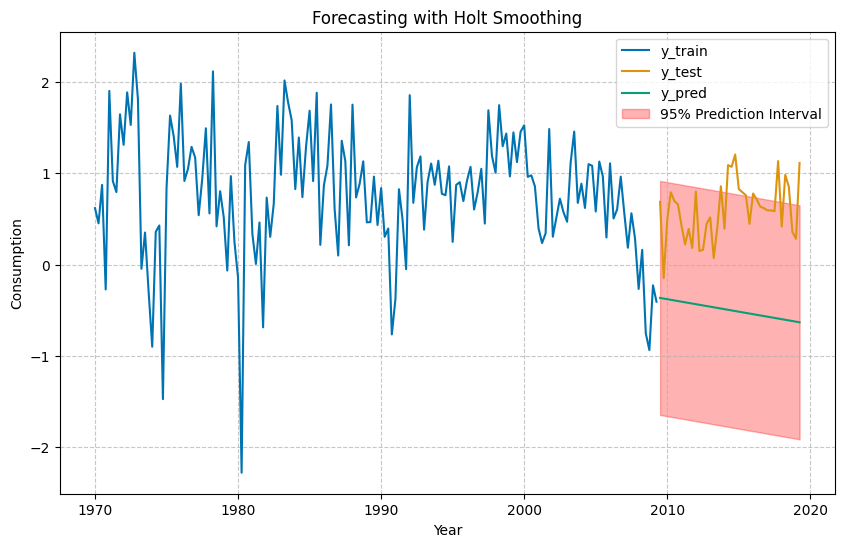

In [6]:
fit_and_plot_smoothing(Consumption["Consumption"], model_type="holt", trend="add")

MAE: 1.08
RMSE: 1.14
MASE: 1.77
R²: -12.41


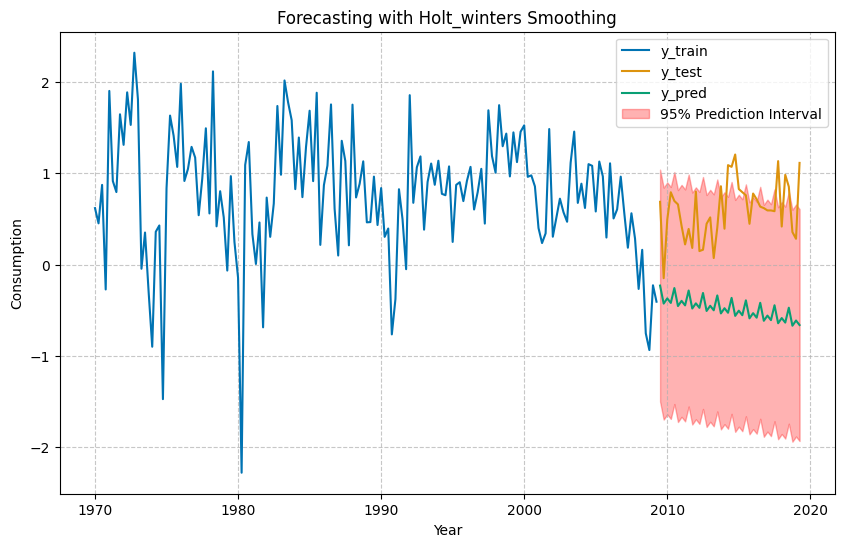

In [7]:
fit_and_plot_smoothing(Consumption["Consumption"], model_type="holt_winters", seasonal="add", seasonal_periods=4)

Os métodos de Holt assumem a tendência e o nível da série temporal. Como discutido anteriormente na sessão de análises, a série não possui uma tendência clara e esses métodos não são os melhores para nossa situação. Portanto, os resultados foram piores até mesmo que a suavização exponencial simples.